**Name**: Dylan Bedetti  
**Student Number**: 21707115   
**Python**: 3.7



# Overview of Assginment

- This lab involves using classification algorithms such as Stochastic Gradient Descent and Logistic Regression
- We preprocess our data by scaling it (this can help the algorithms find patterns in the data)
- We use some crossvalidation and tuning of hyperparameters to see which algorithm will give us the best result


# Task 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
%matplotlib notebook
warnings.simplefilter("ignore")
sns.set()
%matplotlib inline


train = pd.read_csv('training.csv')
test = pd.read_csv('testing.csv')
all_data = pd.concat([train, test])

train.head(5)


,class,b1,b2,b3,b4,b5,b6,b7,b8,b9,...,pred_minus_obs_H_b9,pred_minus_obs_S_b1,pred_minus_obs_S_b2,pred_minus_obs_S_b3,pred_minus_obs_S_b4,pred_minus_obs_S_b5,pred_minus_obs_S_b6,pred_minus_obs_S_b7,pred_minus_obs_S_b8,pred_minus_obs_S_b9
0,d,39,36,57,91,59,101,93,27,60,...,-2.36,-18.41,-1.88,-6.43,-21.03,-1.60,-6.18,-22.50,-5.20,-7.86
1,h,84,30,57,112,51,98,92,26,62,...,-2.26,-16.27,-1.95,-6.25,-18.79,-1.99,-6.18,-23.41,-8.87,-10.83
2,s,53,25,49,99,51,93,84,26,58,...,-1.46,-15.92,-1.79,-4.64,-17.73,-0.48,-4.69,-19.97,-4.10,-7.07
3,s,59,26,49,103,47,92,82,25,56,...,2.68,-13.77,-2.53,-6.34,-22.03,-2.34,-6.60,-27.10,-7.99,-10.81
4,d,57,49,66,103,64,106,114,28,59,...,-2.94,-21.74,-1.64,-4.62,-23.74,-0.85,-5.50,-22.83,-2.74,-5.84


In [2]:
print('The dimensions of the training data: (rows, columns) '+ str(train.shape))
print('The dimensions of the testing data: (rows, columns) '+ str(test.shape))
print('The dimensions of combined data: (rows, columns) '+ str(all_data.shape))

print('\nIs there any null data?: ' + str(all_data.isnull().sum().any()) )
print('\nThe response column has ' + str(all_data['class'].nunique()) +' unique variables')
print('\nThese varibles include: ' + str(list(all_data['class'].unique())))

The dimensions of the training data: (rows, columns) (198, 28)
The dimensions of the testing data: (rows, columns) (325, 28)
The dimensions of combined data: (rows, columns) (523, 28)

Is there any null data?: False

The response column has 4 unique variables

These varibles include: ['d', 'h', 's', 'o']


## Lets plot histograms of all of the numerical data

- this will give us a broad overview of the data

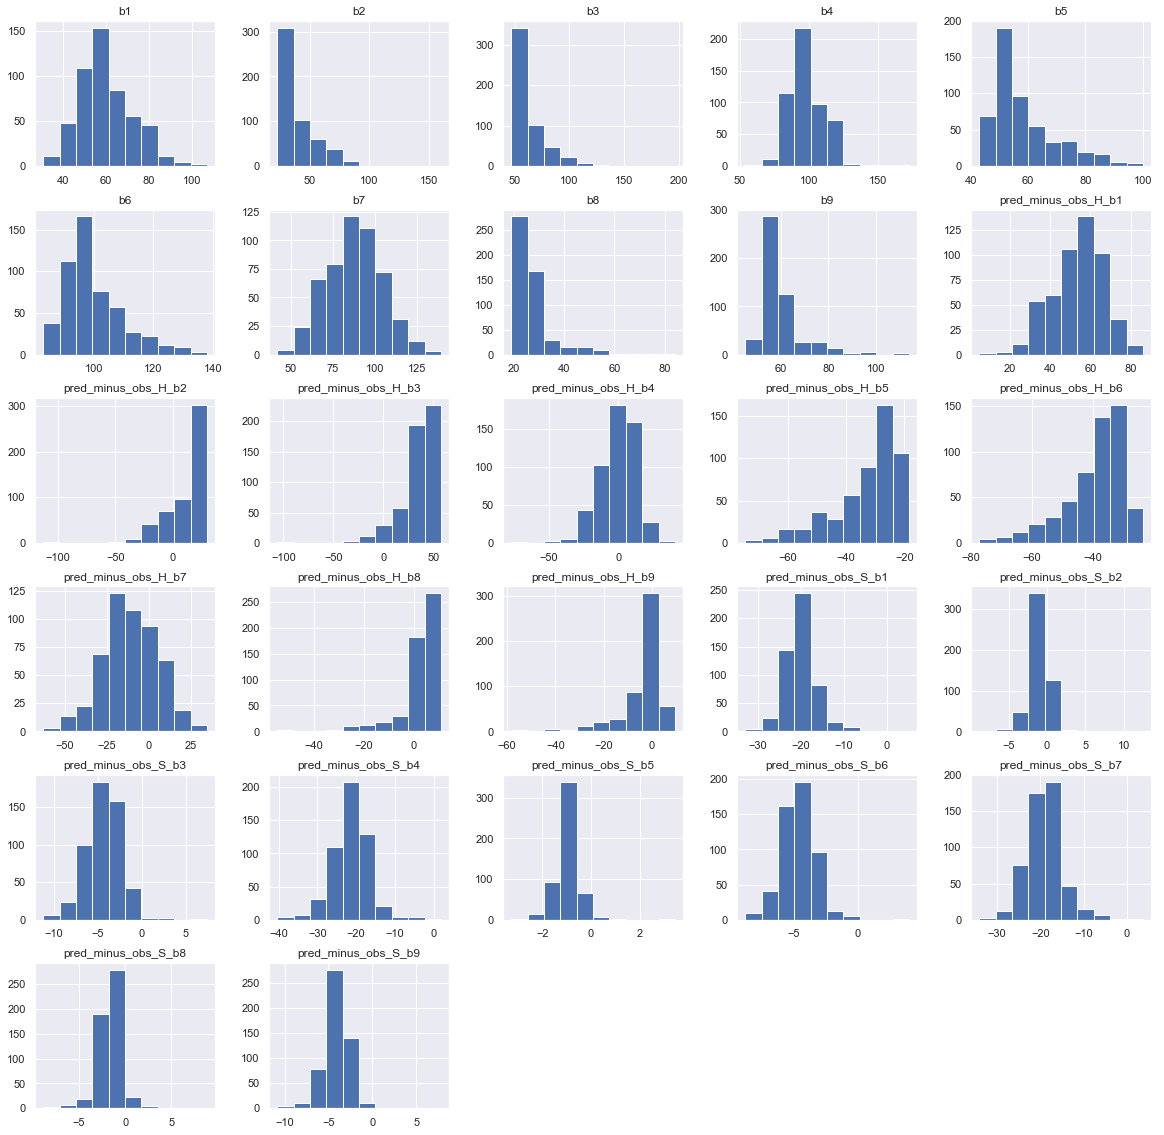

In [3]:
all_data.hist(figsize=(20,20));

## What can we see?
- some of the distributions are approximating normal (such as b7)
- some of the distributions are skewed left or right (such as b5)
- we can actually measure how normal these histograms are by using dimensions of skew and Kurtosis
- we can also see that the ranges of the data is quite variable - this might make it hard for our ML models to find correlations, to solve this we can scale them

Skew: measures the lack of symmetry in data distribution, measures how far it leans left or right.

Kurtosis: This is all about the tails of the distribution, it is a measure of outliers present in the distribution. (can be thought of how fat or skinny the distribution is)

Lets check out our values of Skew and Kurtosis with a plot below

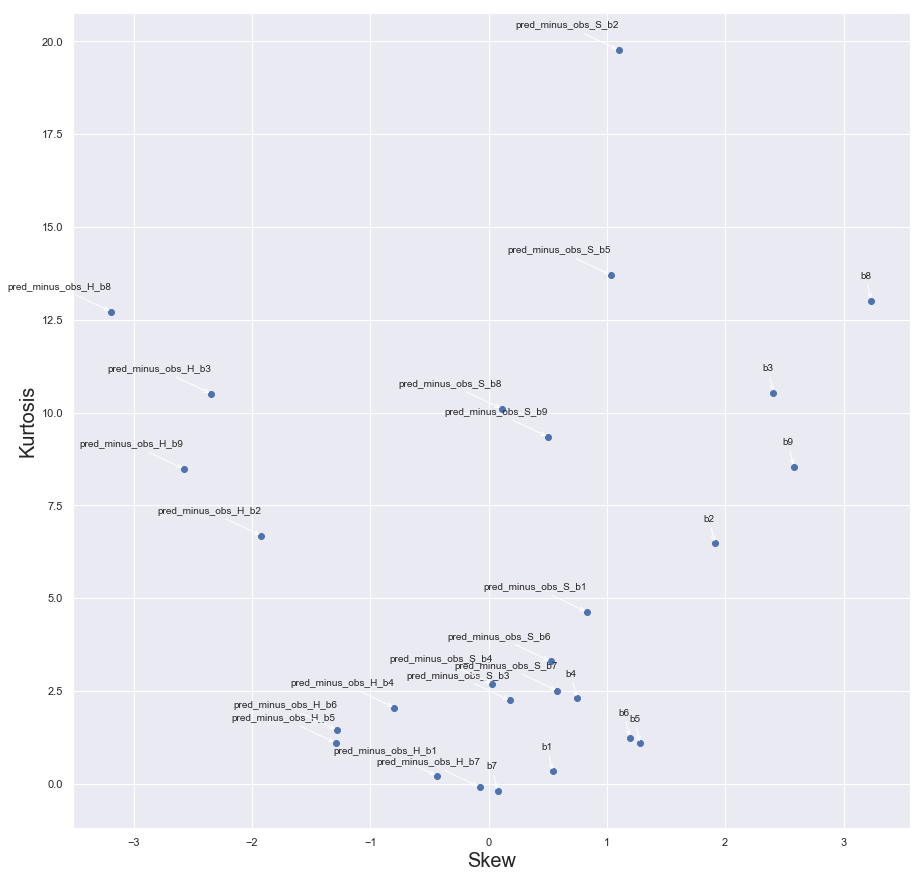

In [4]:
x, y, labels = list(all_data.skew()), list(all_data.kurtosis()), list(all_data.select_dtypes(exclude='object').columns)
plt.figure(figsize=(15, 15))
plt.scatter(x = x,y = y)
plt.xlabel('Skew', fontsize = 20)
plt.ylabel('Kurtosis', fontsize= 20)

for label, x, y in zip(labels, x, y):
    plt.annotate(label, xy = (x,y), xytext = (0, 20), textcoords = 'offset points', ha = 'right', va = 'bottom',
                 arrowprops=dict(arrowstyle = '->'))

# Task 2

In [5]:
cols = [col for col in all_data.columns if col.startswith('pred_minus_obs') != True]
all_data = all_data[cols]
train = train[cols]
test = test[cols]
train.head(5)

,class,b1,b2,b3,b4,b5,b6,b7,b8,b9
0,d,39,36,57,91,59,101,93,27,60
1,h,84,30,57,112,51,98,92,26,62
2,s,53,25,49,99,51,93,84,26,58
3,s,59,26,49,103,47,92,82,25,56
4,d,57,49,66,103,64,106,114,28,59


# Task 3

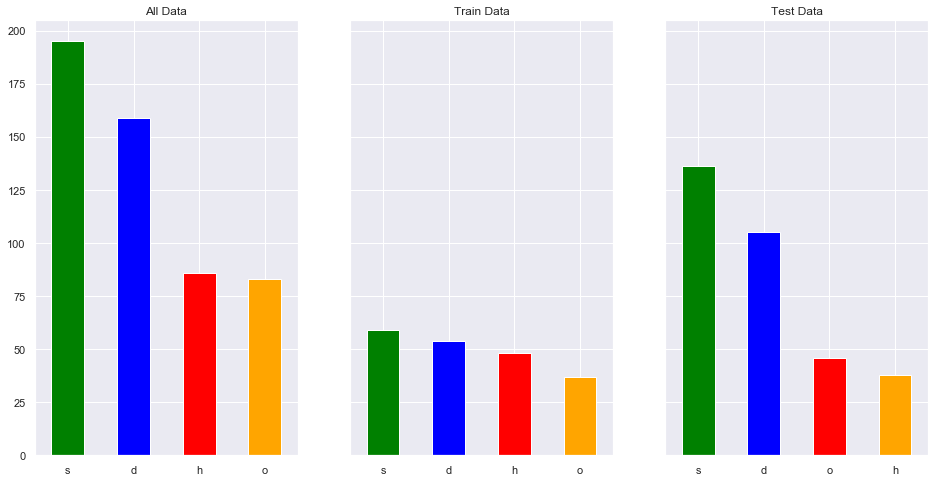

In [6]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (16,8))
all_data['class'].value_counts().plot.bar(rot = 0, ax = ax1, title = 'All Data', color = ['green', 'blue', 'red', 'orange']);
train['class'].value_counts().plot.bar(rot = 0, ax = ax2, title = 'Train Data', color = ['green', 'blue', 'red', 'orange']);
test['class'].value_counts().plot.bar(rot = 0, ax = ax3, title = 'Test Data',color = ['green', 'blue', 'red', 'orange']);

## Results
- the total occurances of all categorical variables seem to within range of eachother (there is no order of magnitude difference)
- train data seems to be the most consistant

# Task 4
- standard scaler is calculated using this z = (x - u) / s

In [7]:
# Most of this code is to support the use of DataFrames in the Pipeline below
# For the task we have been given it is most likely overkill, but I think this is good practice
# for when we will be doing more with data preprocessing

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion, _fit_transform_one, _transform_one
from sklearn.externals.joblib import Parallel, delayed
from scipy import sparse

# This a wrapper around the sklearn StandardScaler - all it is doing it returning a Pandas DataFrame instead of the standard numpy array
class DFStandardScaler(TransformerMixin):

    def __init__(self):
        self.ss = None
        self.mean_ = None
        self.scale_ = None

    def fit(self, X, y=None):
        self.ss = StandardScaler()
        self.ss.fit(X)
        self.mean_ = pd.Series(self.ss.mean_, index=X.columns)
        self.scale_ = pd.Series(self.ss.scale_, index=X.columns)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xss = self.ss.transform(X)
        Xscaled = pd.DataFrame(Xss, index=X.index, columns=X.columns)
        return Xscaled
    
# This is a wrapper around the skleran FeatureUnion - this allows two individual dataframes to be concatenated together     
class PandasFeatureUnion(FeatureUnion):
    
    def fit_transform(self, X, y=None, **fit_params):
        self._validate_transformers()
        result = Parallel(n_jobs=self.n_jobs)(
            delayed(_fit_transform_one)(
                transformer=trans,
                X=X,
                y=y,
                weight=weight,
                **fit_params)
            for name, trans, weight in self._iter())

        if not result:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        Xs, transformers = zip(*result)
        self._update_transformer_list(transformers)
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs

    def merge_dataframes_by_column(self, Xs):
        return pd.concat(Xs, axis="columns", copy=False)

    def transform(self, X):
        Xs = Parallel(n_jobs=self.n_jobs)(
            delayed(_transform_one)(
                transformer=trans,
                X=X,
                y=None,
                weight=weight)
            for name, trans, weight in self._iter())
        if not Xs:
            # All transformers are None
            return np.zeros((X.shape[0], 0))
        if any(sparse.issparse(f) for f in Xs):
            Xs = sparse.hstack(Xs).tocsr()
        else:
            Xs = self.merge_dataframes_by_column(Xs)
        return Xs
    
# This class selected all the columns that are either categorical or numerical based on the cat variabe
# (if cat is true then it selects categorical variables)    
class Select_Cat_or_Num(BaseEstimator, TransformerMixin):
    
    def __init__(self, cat = True):
        self.cat = cat
        
    def fit(self, X, *_):
        if self.cat:
            self.cols = X.select_dtypes(include = 'object').columns.tolist()
        else:
            self.cols = X.select_dtypes(exclude = 'object').columns.tolist()
        return self
    
    def transform(self, X, y = None):
        return X[self.cols]

In [8]:
preprocess_pipeline = Pipeline([
    # feature union will combine all our dataframes
    ('feature_union', PandasFeatureUnion([
        # The numerical pipeline will only select numerical columns and apply a Standard Scaler  
        ('numerical', Pipeline([
            ('select_num',  Select_Cat_or_Num(cat=False)),
            ('SS', DFStandardScaler())
        ])),
        # The categoical Pipeline is used to select the categorical features (in this case this is the class). 
        # we will not tranform this column at all in this pipeline
        ('categorical', Pipeline([
            ('select_cat',  Select_Cat_or_Num(cat=True)),
        ]))
    ]))

])

train_norm = preprocess_pipeline.fit_transform(train)
test_norm = preprocess_pipeline.transform(test)
train_norm.head()

,b1,b2,b3,b4,b5,b6,b7,b8,b9,class
0,-1.878797,-0.282233,-0.386594,-0.704879,0.021654,0.031221,0.154281,-0.188935,-0.114333,d
1,1.651376,-0.619549,-0.386594,0.717192,-0.625526,-0.237548,0.089970,-0.300603,0.090535,h
2,-0.780521,-0.900646,-0.849804,-0.163138,-0.625526,-0.685496,-0.424517,-0.300603,-0.319200,s
3,-0.309831,-0.844427,-0.849804,0.107733,-0.949116,-0.775085,-0.553139,-0.412272,-0.524067,s
4,-0.466728,0.448619,0.134518,0.107733,0.426142,0.479168,1.504812,-0.077266,-0.216766,d


# Explanation of my code above
- I initially create some classes, these are mostly wrappers around already existing sklearn classes which output values in numpy arrays, instead I want outputs to stay in pandas DataFrames. 
- The reason I want it to stay in pandas DataFrames is so I can use a Pipeline easily - this may not be necessary for this lab but it will help when I need to test lots of different hyperparameters or ideas quickly
- I use fit_transform on the train data to get the measured values of the means and standard deviatons, these means and standard deviations will then be applied to the test set (not recalcualted) through the DFStandardScaler Class

# Task 5

> ## 5.1 
I explore a typical multiclass SGDClassifier
> ## 5.2 
I explore one-versus-all SGDClassifier
> ## 5.3
I explore optimisation of a SGDClassifier with f1 scorer

## 5.1

In [9]:
from sklearn.linear_model import SGDClassifier #stochastic gradient descent
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, make_scorer, f1_score

# defining an f1_scorer - this will be used later for the gridsearch
scorer = make_scorer(f1_score, average = 'macro')

# lets create our train X and y DataFrames
train_y = train_norm['class']
train_X = train_norm.drop('class', axis = 1)

# lets create our test X and y DataFrames
test_y = test_norm['class']
test_X = test_norm.drop('class', axis = 1)

# initialising our Classifier, then fitting to the train dataset, then predicting on the test dataset
model1 = SGDClassifier(n_jobs=-1, random_state=1)
model1.fit(X = train_X, y = train_y)
pred = model1.predict(test_X)

# creating our first confusion matrix
labels = ['s', 'd', 'h', 'o']
CF1 = confusion_matrix(test_y, pred, labels = labels)

# accuracy_score just calculates % correct over the total number of predictons
print('model is ' + str(100*accuracy_score(test_y, pred)) +'% accurate')
print( 'f1 score is ' + str(round(100*f1_score(test_y, pred,average = 'macro'), 2)) + '%')

model is 84.3076923076923% accurate
f1 score is 82.27%


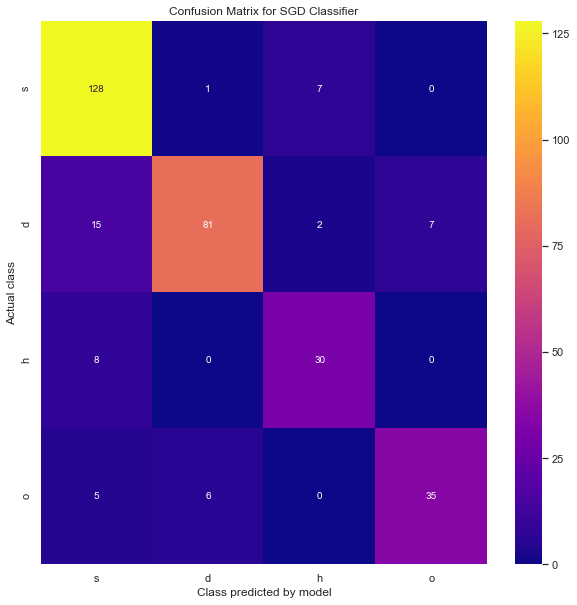

In [10]:
# plotting our confusion matrix
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(CF1, annot=True, fmt = '.4g', xticklabels= labels, yticklabels=labels, cmap = 'plasma');
plt.title('Confusion Matrix for SGD Classifier')
plt.xlabel('Class predicted by model');
plt.ylabel('Actual class');

## 5.2
- What we have just calculated is the confusion matrix for a SGDClassifier with multiclass classification, lets now try it with one-versus-all binary classification

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import f1_score
from statistics import mean

# creating f1 list for collecting values
f1 = []

# encoding both test and train datasets
train_encoded = label_binarize(train_y, classes=['s', 'd', 'h', 'o'])
train_encoded = pd.DataFrame(data = train_encoded, columns = ['class_s', 'class_d', 'class_h', 'class_o'])
test_encoded = label_binarize(test_y, classes=['s', 'd', 'h', 'o'])
test_encoded = pd.DataFrame(data = test_encoded, columns = ['class_s', 'class_d', 'class_h', 'class_o'])

# for loop which is doing one-versus all for each class
for i in range(4):
    model1.fit(X = train_X, y = train_encoded.iloc[:, i])
    pred = model1.predict(test_X)
    print(str(labels[i]) + ' accuracy is ' + str(round(100*accuracy_score(test_encoded.iloc[:, i], pred), 2)) + '%  ', end = '')
    print('f1 score is ' + str(round(100*f1_score(test_encoded.iloc[:, i], pred), 2)) + '%')
    f1.append(round(100*f1_score(test_encoded.iloc[:, i], pred), 2))
print('average f1 score is: ' + str(round(mean(f1), 2))+ '%' )

s accuracy is 82.77%  f1 score is 81.94%
d accuracy is 88.92%  f1 score is 82.0%
h accuracy is 94.77%  f1 score is 80.0%
o accuracy is 94.15%  f1 score is 78.65%
average f1 score is: 80.65%


## Explanation of high accuracy
- Above we are seeing accuracy scores of around 94% for one-versus-all binary classification, however this may not be an accurate representation of how our model will perfrom on a new dataset
- when we binaries our class column we are skewing the each of the individual one-versus-all columns
- each binarised column contains around 75% 0's and 25% 1's
- This means that if the model was to ignore the data and only predict 0's it would already have an accuracy of 75% !
- therefore the model is not learning the data, it is learning the skew of the dataset

## How can we measure accuracy?
- here accuracy is just a percentage of correct over not correct - however this does not take into the account measures of precision and recall
- To take full advantage of both precision, recall and the skewness of the dataset we can use the f1 score that is provided by sklearn 
- the f1 score is calcuate by this: $ F1 = 2 * (precision * recall) / (precision + recall) $
- we can then use this score to compare against other machine learning (such as Logistic Regression that we will explore further below)

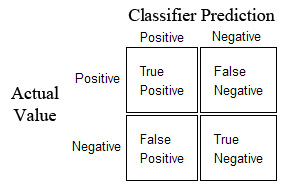
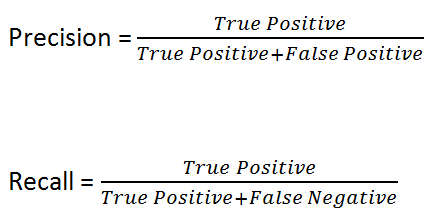

## we can also plot all the indiviudal confusion matricies 

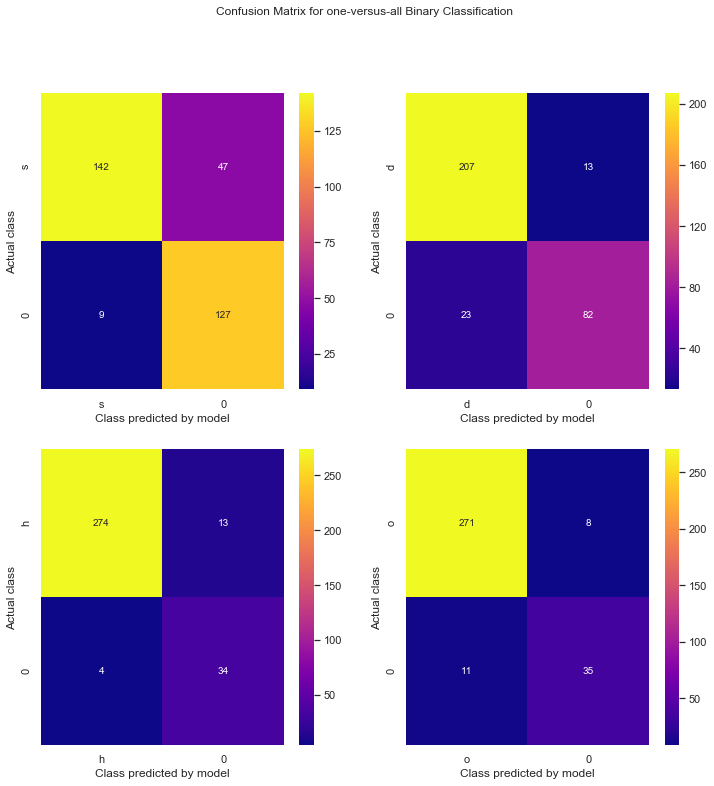

In [12]:
# creating the figure and axes for the subplots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize = (12,12))
ax = [ax1, ax2, ax3, ax4]
f.suptitle('Confusion Matrix for one-versus-all Binary Classification')

# looping through and plotting all of the confusion matricies 
for i in range(4):
    model1.fit(X = train_X, y = train_encoded.iloc[:, i])
    pred = model1.predict(test_X)
    CF = confusion_matrix(test_encoded.iloc[:, i], pred)
    sns.heatmap(CF, annot=True, fmt = '.4g',cmap = 'plasma', ax = ax[i], xticklabels= [labels[i], '0'], yticklabels= [labels[i], '0']);
    ax[i].set_title('')
    ax[i].set(xlabel='Class predicted by model', ylabel='Actual class')

## 5.3
- Lets try and optimise this Stochastic Gradient Descent Algorithm using Cross Validation
- instead of using one-versus-all binary classification lets use multiclass classification and determine what the best accuracy we can get is


In [13]:
# selecting the hyperparamters
# these hyperparamters were chosing from reading the sklearn reference page for SGD
# the hyperparameters were updates based on the best_score_ to try and optimise this

parameters = {
    'loss':('hinge', 'log'),
    'penalty':('l2', 'l1'),
    'alpha':[0.00001, 0.0001, 0.001],
    'l1_ratio': [0.05, 0.10, 0.20],
    'max_iter': [100, 1000]
}

# setting up the grid search cross validation with 5 folds
clf = GridSearchCV(model1, parameters, cv=5, verbose = 1, scoring=scorer)
clf.fit(train_X, train_y);

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:   46.7s finished
C:\Users\dylan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [14]:
print('Best score and parameter combination = ')
print(clf.best_score_)    
print(clf.best_params_)  

Best score and parameter combination = 
0.9536910315374014
{'alpha': 0.0001, 'l1_ratio': 0.05, 'loss': 'log', 'max_iter': 100, 'penalty': 'l2'}


# Task 6

> ## 6.1 
I explore a typical multiclass LR
> ## 6.2 
I explore optimising LR using f1 score
> ## 6.3
I explore the softmax function


## 6.1

In [15]:
from sklearn.linear_model import LogisticRegression

# using lbfgs as it is the only optimisier that allows softmax
model2 = LogisticRegression(n_jobs=-1, random_state=1, multi_class= 'multinomial', solver= 'lbfgs')
model2.fit(X = train_X, y = train_y)
pred = model2.predict(test_X)

# setting up my labels for the plot and calcualting the confusion matrix
labels = ['s', 'd', 'h', 'o']
CF2 = confusion_matrix(test_y, pred, labels = labels)

# looking at different scores
print('accuracy is ' + str(round(100*accuracy_score(test_y, pred), 2)) +'%')
print( 'f1 score is ' + str(round(100*f1_score(test_y, pred,average = 'macro'), 2)) + '%')

# there is a small difference between the accuracy and f1 scores. 
# I beleive f1 score is a more accurate way of calculating the performance of a classification model - this is because it takes
# into account both precision and recall

accuracy is 83.69%
f1 score is 81.33%


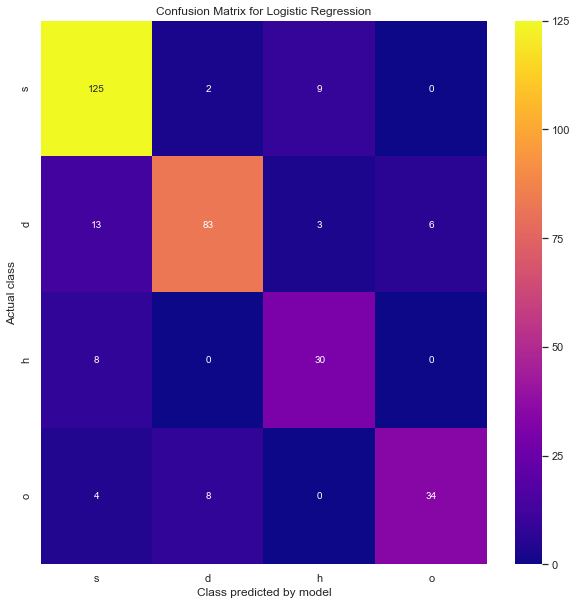

In [16]:
# plotting the confusion matrix
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(CF2, annot=True, fmt = '.4g', xticklabels= labels, yticklabels=labels, cmap = 'plasma');
plt.title('Confusion Matrix for Logistic Regression')
plt.xlabel('Class predicted by model');
plt.ylabel('Actual class');

## 6.2

- Lets try and optimise this Logistic Regression Algorithm using Cross Validation

In [17]:
# selecting the hyperparamters
# these hyperparamters were chosing from reading the sklearn reference page for Logistic regression
# the hyperparameters were updated based on the best_score_ to try and optimise this
parameters = {
    'tol':[2, 1, 0.1, 0.01],
    'C': [50, 20, 10, 1, 0.5],
    'max_iter': [5, 20 ,50]
}

# setting up the grid search cross validation with 5 folds
clf = GridSearchCV(model2, parameters, cv=5, verbose = 1, scoring= scorer)
clf.fit(train_X, train_y);

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 300 out of 300 | elapsed:   15.2s finished
C:\Users\dylan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [18]:
print('Best score and parameter combination = ')
print(clf.best_score_)    
print(clf.best_params_)  

Best score and parameter combination = 
0.9440841325844355
{'C': 50, 'max_iter': 20, 'tol': 1}


## 6.3
- We can also visualise the prediction probability for each row in the test set 
- this uses the softmax function 

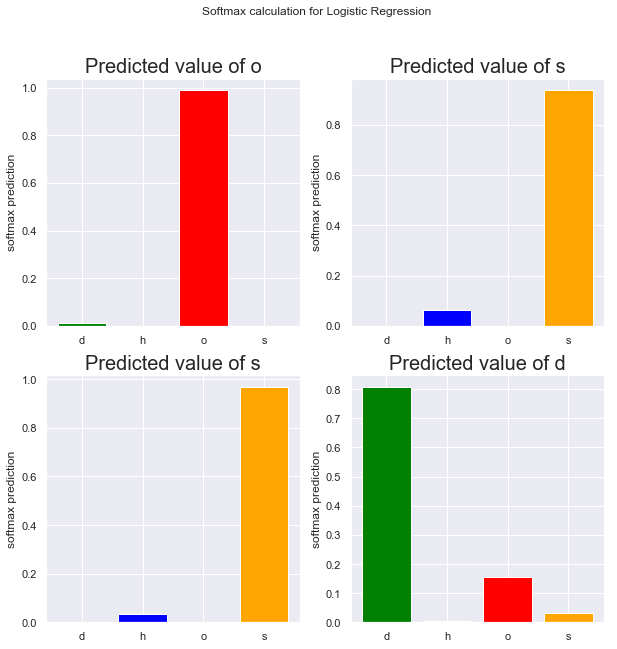

In [19]:
# creating the figure and axes for the subplots
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize= (10,10))
f.suptitle('Softmax calculation for Logistic Regression')
ax = [ax1, ax2, ax3, ax4]
pred = clf.predict(test_X)

# for loop for plotting the softmax predictions
for i in range(4):
    ax[i].bar(x = ['d','h','o','s'],height = clf.predict_proba(test_X)[i], color = ['green', 'blue', 'red', 'orange'])
    ax[i].set_title('Predicted value of ' + str(pred[i]), fontsize = 20)
    ax[i].set(ylabel='softmax prediction')

# Task 7

## My Conclusion

After testing both the SGD and LR algorithms through a vairety of hyperparameters while using hyperparameters the final results were:

SGD - multiclass : f1-score = 95.3%  
SGD - one-versus-all: f1-score = 80.65%  
LR : f1-score = 94.4%

In conclusion the Stochastic Gradient Descent algorithm is the best algorithm with an accuracy of 95.4% however the LR is not far behind.

We can also see the difference of one-versus-all vs multiclass regression, we are a lot more accurate when we use multiclass regression. 

Classification is an interesting problem - as there is no simple way of measuring accuracy and converting from one-versus-all to multiclass regression presents some problems for determining accuracy. 

# EXTRA STUFF
## Lets see if we can get some cool visualisations 
- I used TSNE dimensionality reduction to enable 2D and 3D visualisations of our data

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 1.079386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.692783
[t-SNE] KL divergence after 1000 iterations: 0.194840


<IPython.core.display.Javascript object>


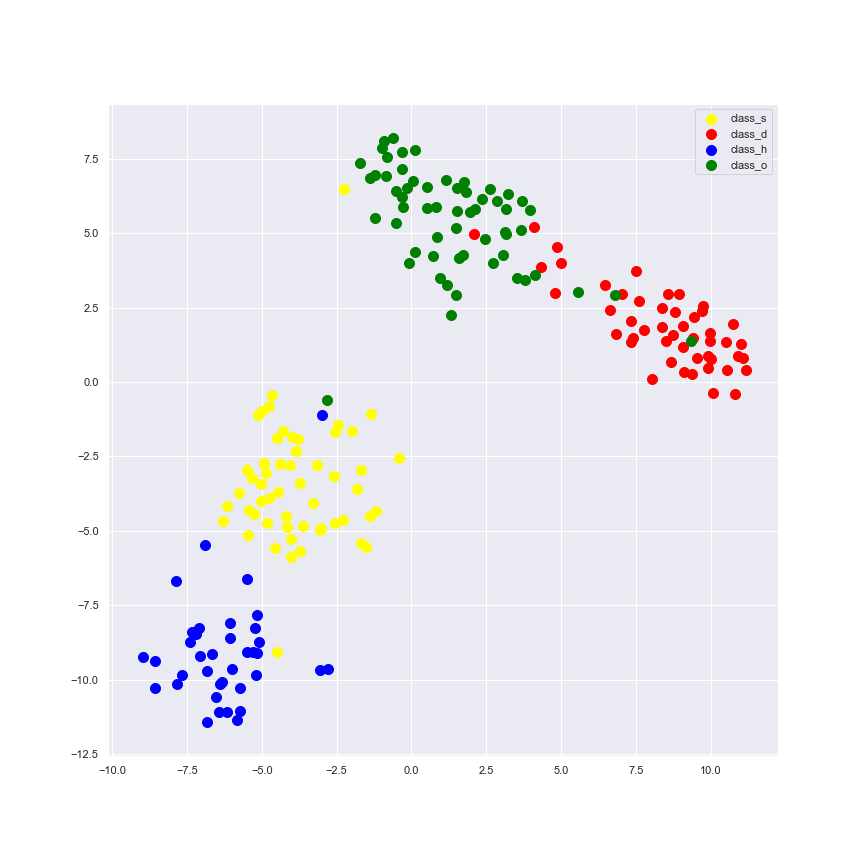

In [22]:
%matplotlib notebook
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
LE = LabelEncoder()
groups = LE.fit_transform(train_y)

labels =  ['class_s', 'class_d', 'class_h', 'class_o']
cdict = {1: 'red', 2: 'blue', 3: 'green', 0: 'yellow'}

tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=1000)
tsne = tsne.fit_transform(train_X, train_y)

fig, ax = plt.subplots(figsize = (12,12))
for g in np.unique(groups):
    ix = np.where(groups == g)
    ax.scatter(tsne[ix, [0]], tsne[ix, [1]], c = cdict[g], label = labels[g], s =100)
ax.legend()
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 198 samples in 0.000s...
[t-SNE] Computed neighbors for 198 samples in 0.000s...
[t-SNE] Computed conditional probabilities for sample 198 / 198
[t-SNE] Mean sigma: 1.079386
[t-SNE] KL divergence after 250 iterations with early exaggeration: 98.775627
[t-SNE] KL divergence after 1000 iterations: 1.482401


<IPython.core.display.Javascript object>


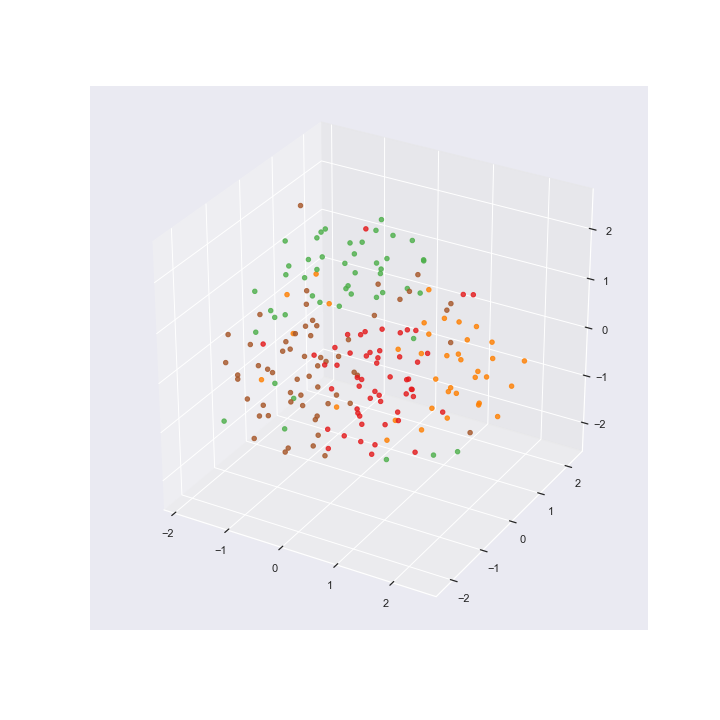

In [21]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne = tsne.fit_transform(train_X)
tsne = StandardScaler().fit_transform(tsne)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111,projection='3d')
plt.grid()

for label_id in np.unique(groups):
    ax.scatter(tsne[np.where(groups == label_id), 0],
                tsne[np.where(groups == label_id), 1],
                tsne[np.where(groups == label_id), 2],
                alpha=0.8,
                color= plt.cm.Set1(label_id / float(4)),
                marker='o',
                label=labels[g])
plt.show()